In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

data = pd.read_csv('../data/processed/compas-scores-two-years-processed.csv')
data.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,jail_time,sex,race,c_charge_degree,decile_score,two_year_recid,compas_score,compas_class
0,69,0,0,0,0,0.0,1,1,1,1,0,0.1,0
1,34,0,0,0,0,10.0,1,2,1,3,1,0.3,0
2,24,0,0,1,4,1.0,1,2,1,4,1,0.4,0
3,23,0,1,0,1,0.0,1,2,1,8,0,0.8,1
4,43,0,0,0,2,0.0,1,1,1,1,0,0.1,0


In [2]:
DROP_COLS = ['two_year_recid','compas_score','decile_score','compas_class']
FEATURE_COLS = data.drop(DROP_COLS, axis=1).columns.tolist()

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=1234)

In [4]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(test['two_year_recid'], test['compas_score'])
roc_auc

0.7012452309472434

# Notes on tools

## Tool list with links
* [facets](https://pair-code.github.io/facets/) Data exploration

<img src="../images/facets.png" alt="Drawing" style="width: 600px;"/>

* [fairml](https://github.com/adebayoj/fairml) black-box model audits

<img src="../images/fairml.png" alt="Drawing" style="width: 600px;"/>

* **[aif360](http://aif360.mybluemix.net) Full suit of tools metrics + bias mitigation algorithms**

<img src="../images/aif360.png" alt="Drawing" style="width: 600px;"/>

# Metrics

## Useful concepts

**Privilaged and unprivilaged groups**

Sometimes we can define a group that are biased positive/negatively in advance and keep track of them later.

**Protected columns**

Columns representing features that we want to protect like race or sex.

**Favorable and unfavorable labels**

Sometimes positive label is actually a bad thing. In our example, prediction that a suspect will re-ofend is unfavorable. 

## Metric "groups"

**Performance Difference/Ratio metrics**

You can calculate all the standard performance metrics like false-positive rates, accuracy, precision or recall (equal opportunity) for privileged and unprivileged group separately and see the difference or a ratio of those values.

**Entropy Based metrics**

Generalized entropy is calculated for each group and then compared. This [method can be used to measure fairness](https://arxiv.org/abs/1807.00787) not only at a group level but also at the individual level. The most commonly used flavor of generalized entropy is the Theil index, originally used to measure income inequality.

In [6]:
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

BIAS_INFO = {'favorable_label':0,
             'unfavorable_label':1,
             'protected_columns':['race']
            }
PRIVILEGED_INFO = {'unprivileged_groups':[{'race': 2},
                                          {'race': 1},
                                          {'race': 4},
                                          {'race': 5},
                                          {'race': 6}],
                   'privileged_groups':[{'race': 3}]
                  }

def make_dataset(features, labels, scores=None, protected_columns=None,
                 privileged_groups=None, unprivileged_groups=None, 
                 favorable_label=None, unfavorable_label=None):
    df = features.copy()
    df['outcome'] = labels
    
    if scores is not None:
        scores_names = 'scores'
        df[scores_names] = scores
    else:
        scores_names = []

    dataset = BinaryLabelDataset(df=df, label_names=['outcome'], scores_names=scores_names,
                                 protected_attribute_names=protected_columns,
                                 favorable_label=favorable_label, unfavorable_label=unfavorable_label,
                                 unprivileged_protected_attributes=unprivileged_groups)
    return dataset

ground_truth_test = make_dataset(test[FEATURE_COLS], test['two_year_recid'], **BIAS_INFO, **PRIVILEGED_INFO)
prediction_test = make_dataset(test[FEATURE_COLS], test['compas_class'], test['compas_score'], **BIAS_INFO, **PRIVILEGED_INFO)
 
clf_metric = ClassificationMetric(ground_truth_test, prediction_test,**PRIVILEGED_INFO)

## Confusion Matrix by group

In [7]:
print(clf_metric.binary_confusion_matrix(privileged=True))
print(clf_metric.binary_confusion_matrix(privileged=False))
print(clf_metric.binary_confusion_matrix(privileged=None))

{'TP': 252.0, 'FP': 137.0, 'TN': 56.0, 'FN': 27.0}
{'TP': 430.0, 'FP': 231.0, 'TN': 203.0, 'FN': 107.0}
{'TP': 682.0, 'FP': 368.0, 'TN': 259.0, 'FN': 134.0}


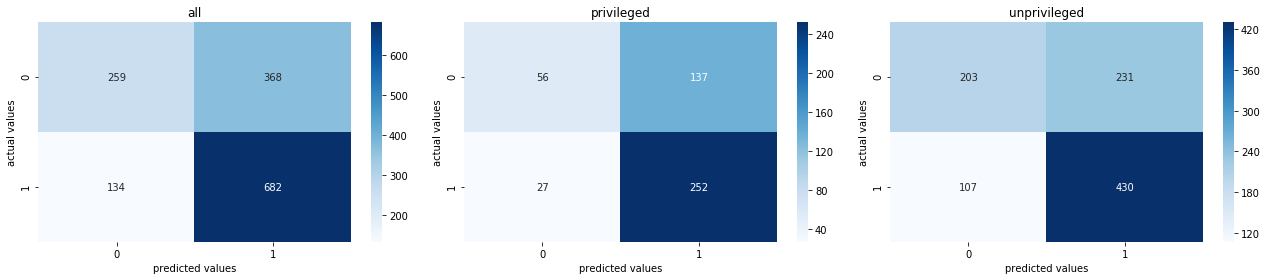

In [8]:
import matplotlib.pyplot as plt
from utils import plot_confusion_matrix_by_group

fig = plot_confusion_matrix_by_group(clf_metric)
plt.tight_layout()
plt.show()

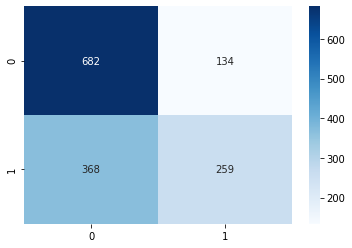

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test['two_year_recid'], test['compas_class'])
sns.heatmap(cm, annot=True, cmap=plt.get_cmap('Blues'), fmt='g')

### Questions

- Why aif360 confusion matrix is flipped?

## Performance metrics by group

You should measure differences in "normal" metrics between privalaged and unprivilaged groups

In [10]:
print(clf_metric.performance_measures(privileged=True))
print(clf_metric.performance_measures(privileged=False))
print(clf_metric.performance_measures(privileged=None))

{'TPR': 0.9032258064516129, 'TNR': 0.29015544041450775, 'FPR': 0.7098445595854922, 'FNR': 0.0967741935483871, 'GTPR': 0.3096774193548387, 'GTNR': 0.5139896373056995, 'GFPR': 0.4860103626943005, 'GFNR': 0.6903225806451614, 'PPV': 0.6478149100257069, 'NPV': 0.6746987951807228, 'FDR': 0.35218508997429304, 'FOR': 0.3253012048192771, 'ACC': 0.652542372881356}
{'TPR': 0.8007448789571695, 'TNR': 0.46774193548387094, 'FPR': 0.532258064516129, 'FNR': 0.19925512104283055, 'GTPR': 0.3972067039106145, 'GTNR': 0.3960829493087557, 'GFPR': 0.6039170506912442, 'GFNR': 0.6027932960893855, 'PPV': 0.6505295007564297, 'NPV': 0.6548387096774193, 'FDR': 0.3494704992435703, 'FOR': 0.34516129032258064, 'ACC': 0.6519052523171988}
{'TPR': 0.8357843137254902, 'TNR': 0.4130781499202552, 'FPR': 0.5869218500797448, 'FNR': 0.1642156862745098, 'GTPR': 0.36727941176470597, 'GTNR': 0.4323763955342902, 'GFPR': 0.5676236044657097, 'GFNR': 0.6327205882352942, 'PPV': 0.6495238095238095, 'NPV': 0.6590330788804071, 'FDR': 0.

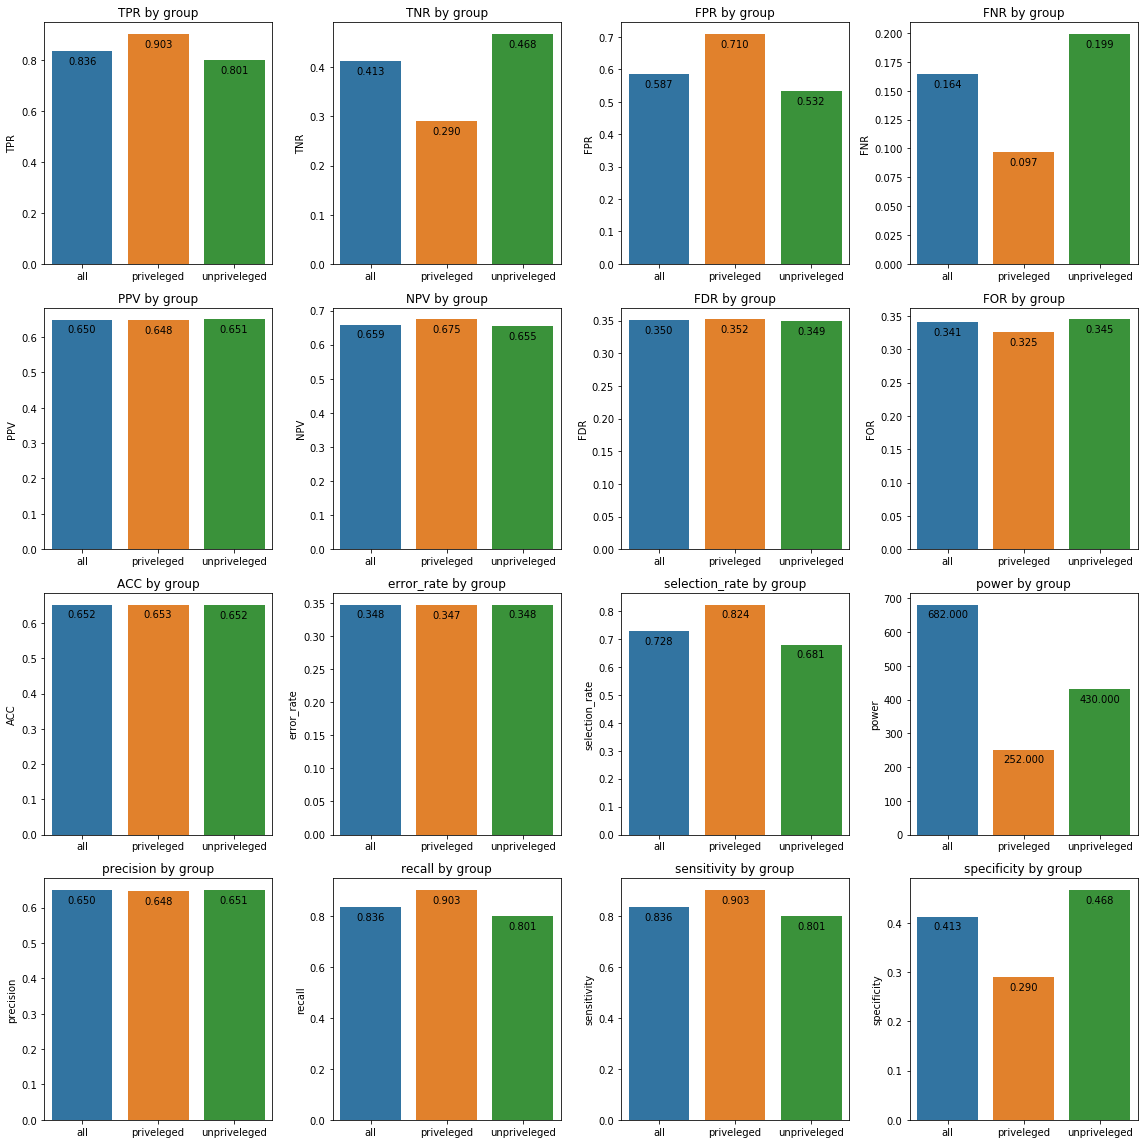

In [11]:
from utils import plot_performance_by_group

group_metrics = ['TPR', 'TNR', 'FPR', 'FNR', 'PPV', 'NPV', 'FDR', 'FOR', 
                 'ACC', 'error_rate', 'selection_rate', 'power',
                 'precision', 'recall', 'sensitivity', 'specificity', 
                ]

fig, axs = plt.subplots(4,4,figsize=(16,16))
for i, metric in enumerate(group_metrics):
    plot_performance_by_group(clf_metric, metric, axs[i//4,i%4])
    plt.tight_layout()

## Difference

**Unprivileged - Priviliged**

In [ ]:
print(clf_metric.true_positive_rate_difference())
print(clf_metric.false_positive_rate_difference())
print(clf_metric.false_negative_rate_difference())
print(clf_metric.false_omission_rate_difference())
print(clf_metric.false_discovery_rate_difference())
print(clf_metric.error_rate_difference())
print(clf_metric.average_odds_difference())

## Ratio

**Unprivileged / Priviliged**

In [ ]:
print(clf_metric.false_positive_rate_ratio())
print(clf_metric.false_negative_rate_ratio())
print(clf_metric.false_omission_rate_ratio())
print(clf_metric.false_discovery_rate_ratio())
print(clf_metric.error_rate_ratio())

### Questions

- Which group has higher FPR, FNR, Recall, Precision?
- Is this model fair? If not why?

## "Classical" Fairness metrics

### Disparate impact & Statistical parity

- Disparate impact: Ratio of selection rates. 
- Statistical parity: Difference of selection rates. 

Disparity between how often members of the unprivileged/privileged groups get impacted.

In [12]:
print(clf_metric.disparate_impact())
print(clf_metric.statistical_parity_difference())

0.825989690748943
-0.14341103876834993


### Questions

- Which group is affected negatively?
- Is it fair?

### Equal opportunity

Difference between True Positive Rates.

Model should give equal opportunity by selecting members at the same TPR for each group.

In [13]:
print(clf_metric.equal_opportunity_difference())

-0.10248092749444337


### Entropy index

- Originaly proposed to measure income inequality
- In the case of classification, closely related to accuracy (y_true - y_pred in the formulas)
- Theil index alpha = 1
- Coefficient of variation alpha = 2
- The closer to 0 the better
- Can generalize to multiclass labels
- Can deal with individual fairness

[Read a paper by Till Speicher and others](https://arxiv.org/pdf/1807.00787.pdf)

In [14]:
print(clf_metric.generalized_entropy_index())
print(clf_metric.between_group_generalized_entropy_index())
print(clf_metric.between_all_groups_generalized_entropy_index())

print(clf_metric.coefficient_of_variation())
print(clf_metric.between_group_coefficient_of_variation())
print(clf_metric.between_all_groups_coefficient_of_variation())

print(clf_metric.theil_index())
print(clf_metric.between_group_theil_index())
print(clf_metric.between_all_groups_theil_index())

0.11905257172969468
0.0009043012975655249
0.002496704926202599
0.6900799134294366
0.06014320568661185
0.099934076794707
0.1539255041015982
0.0008952605489393357
0.0024769932991006967


### Questions

- Individual fairness vs accuracy, what is the difference?
- Which metrics should we care about for this problem?

# Display fairness metrics

In [16]:
import joblib
from utils import display_results

joblib.dump((clf_metric, roc_auc), '../results/0.1-compas_model-race.pkl')
display_results('../results/0.1-compas_model-race.pkl')

,metric_names,scores
0,roc_auc_score,0.701245
1,true_positive_rate_difference,-0.102481
2,false_positive_rate_difference,-0.177586
3,false_omission_rate_difference,0.019860
4,false_discovery_rate_difference,-0.002715
5,error_rate_difference,0.000637
6,false_positive_rate_ratio,0.749823
7,false_negative_rate_ratio,2.058970
8,false_omission_rate_ratio,1.061051
9,false_discovery_rate_ratio,0.992292


## Questions

**On which metrics should we focus and why?**